# Bayesian Estimation and Forecasting of Time Series in Statsmodels

[``Statsmodels``](https://www.statsmodels.org/), a Python library for statistical and econometric analysis,
has traditionally focused on frequentist inference, including in its
models for time series data. This Poster illustrates the powerful
features for Bayesian inference of time series models that exist in
``statsmodels``, with applications to model fitting, forecasting, time series
decomposition, data simulation, and impulse response functions.

**Suggestions for reading and using this Poster**

Our suggestion for using this Poster is as follows.

1. The most accessible place to start is the [paper](https://github.com/ChadFulton/scipy2022-bayesian-time-series/blob/main/Bayesian%20Estimation%20and%20Forecasting%20of%20Time%20Series%20in%20statsmodels.pdf). It is relatively short, and
   guides the reader through the main concepts and key code segments.
2. The poster itself is a Jupyter notebook, [`Poster.ipynb`](https://github.com/ChadFulton/scipy2022-bayesian-time-series/blob/main/Poster.ipynb), and it can be (a)
   run to reproduce the analysis and figures in the paper, and (b) copied and
   modified to apply these tools and concepts to whatever project the reader
   wishes!
3. For readers who wish to go further, additional resources on Bayesian analysis
   of time series models in Statsmodels are listed below.

More details about each of these follow:

**1. Paper**

Included in this repository is a draft of the paper
[`Bayesian Estimation and Forecasting of Time Series in Statsmodels.pdf`](https://github.com/ChadFulton/scipy2022-bayesian-time-series/blob/main/Bayesian%20Estimation%20and%20Forecasting%20of%20Time%20Series%20in%20statsmodels.pdf) that is
forthcoming in the Proceedings of the 21st Python in Science Conference (SciPy
2022). This paper introduces the time series models included in Statsmodels and
shows how to estimate their parameters using Bayesian methods. It also briefly
describes the relationship to other popular Python libraries for Bayesian
inference, including [PyMC](https://www.pymc.io/projects/docs/en/stable/learn.html), [PyStan](https://pystan.readthedocs.io/en/latest/), and [ArviZ](https://www.arviz.org/en/latest/).

**2. Poster**

The paper also provides code samples for several applications that include
parameter estimation, forecasting, and causal inference. To keep the paper
readable, the code included inline is only brief, but the Poster included in
this repostory, [`Poster.ipynb`](https://github.com/ChadFulton/scipy2022-bayesian-time-series/blob/main/Poster.ipynb), is a Jupyter notebook that contains the complete
code for performing the Bayesian analysis in the paper.

**3. Additional resources for Bayesian analysis of time series models in Statsmodels**


- [Autoregressive moving average (ARMA) model](https://www.chadfulton.com/topics/arma11_cpi_inflation.html).
  This Jupyter notebook shows how to estimate the parameters of an `SARIMAX`
  model (which is already built-in to Statsmodels) using Bayesian methods.
- [Stochastic volatility model](https://www.chadfulton.com/topics/stochastic_volatility_mcmc.html).
  This Jupyter notebook shows (a) how to create a custom state space model that
  represents a stochastic volatility process, (b) how to apply it to an exchange
  rate time series, and (c) how to then estimate the parameters using
  Bayesian methods.
- [Time-Varying Parameter Vector Autoregression (TVP-VAR) model](https://www.chadfulton.com/topics/statespace_tvpvar_mcmc_cfa.html).
  This Jupyter notebook shows (a) how to create a custom state space model that
  represents a TVP-VAR model, and (b) how to then estimate the parameters using
  Bayesian methods.
- [Dynamic stochastic general equilibrium (DSGE) economic model](https://www.chadfulton.com/topics/simple_rbc.html).
  This Jupyter notebook shows how to set up and solve a simple Real Business
  Cycle economic model, and how to estimate its structural parameters using
  Bayesian methods.


In [1]:
# Basic scientific libraries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Statsmodels is the primarily library used here
# for Bayesian inference of time series models
import statsmodels.api as sm

# Output from Markov chain Monte Carlo (MCMC)
# simulations is naturally multidimensional and
# tends to be quite large. The xarray and ArviZ
# libraries make it easy to work with.
import xarray as xr
import arviz as az

# Formatting settings for the notebook
np.set_printoptions(suppress=True, linewidth=120)

## Application 1: estimating the parameters of a random walk model with random walk Metropolis-Hastings

Our first application applies one of the simplest time series models - the random walk - to U.S. Industrial Production.

The random walk model is as follows:

$$
\begin{aligned}
y_t & = y_{t-1} + \varepsilon_t, \qquad \varepsilon_t \sim N(0, \sigma^2)
\end{aligned}
$$

This model is useful for illustrating the key aspects of Bayesian inference using Statsmodels because it is very simple - it only has a single parameter, $\sigma^2$.

Before setting up the model, we will read in the data. Here we are using [U.S. Industrial Production](https://fred.stlouisfed.org/series/IPB50001N), taken from the FRED database made available by the Federal Reserve Bank of St. Louis.

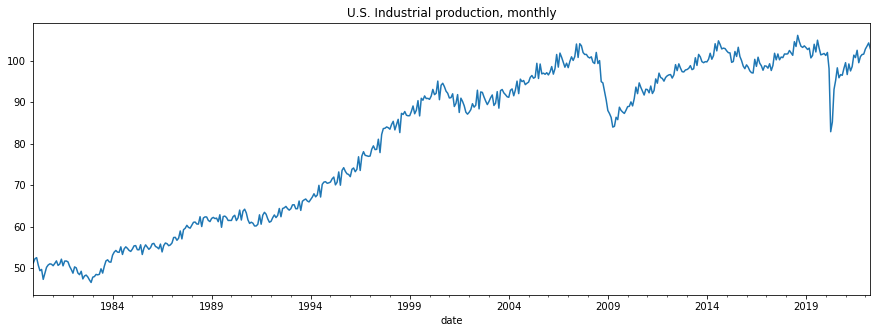

In [2]:
from pandas_datareader.data import DataReader
# Load data and assign the correct date index
y = DataReader('IPB50001N', 'fred', start='1980', end='2022-04')['IPB50001N'].asfreq('MS')
y.index.name = 'date'

# Plot the data
y.plot(title='U.S. Industrial production, monthly', figsize=(15, 5));

### Constructing a random walk model using `UnobservedComponents`

The `UnobservedComponents` model included in Statsmodels can be used to construct a large number of models that decompose a given time series into trend, seasonal, cyclical, and irregular components (it can also accommodate explanatory variables and autoregressive dynamics). The random walk model shown above is one of the simplest versions.

**Note**: when parameters are estimated with Bayesian methods, the models that can be constructed using `UnobservedComponents` are often referred to as *Bayesian Structural Time Series Models* (BSTS).

In [3]:
# Construct an object that contains our dataset, `y`,
# and specifies the model, here a random walk
model_rw = sm.tsa.UnobservedComponents(y, 'random walk')

# Check the parameters that the model depends on only
# include a variance term:
print(model_rw.param_names)

['sigma2.level']


### Estimating $\sigma^2$ using random-walk Metropolis-Hastings (RWMH)

Bayesian inference combines a prior with the likelihood of the data (conditional on the chosen model). Through the model class `UnobservedComponents`, Statsmodels makes available the likelihood function, but we do need to choose our prior.

One benefit of using RWMH is that it does not restrict our choice of prior (unlike Gibbs sampling, described below). To illustrate that flexibility, here we will use a uniform prior, with support over $(0.0001, 100)$.

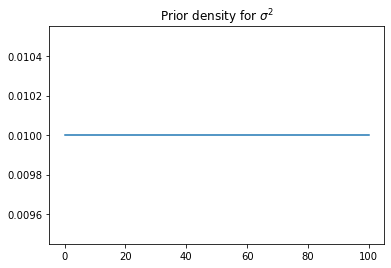

In [4]:
# Prior distribution
prior = stats.uniform(0.0001, 100)

# Plot the density
X = np.linspace(0.0001, 100, num=1000)
fig, ax = plt.subplots()
ax.plot(X, prior.pdf(X))
ax.set_title(r'Prior density for $\sigma^2$');

Because Random walk Metropolis-Hastings begins each iteration by perturbing the sample from the prior iteration, we also need to specify the perturbation distribution that we will be using. Since we will typically use a Normal distribution centered at zero, the only parameter to select here is the standard deviation. Since this is a simple illustration, we will simply choose the standard deviation to be 0.1.

In [5]:
# Perturbation distribution
perturb = stats.norm(scale=0.1)

Now we perform the Markov chain Monte Carlo iterations. We first set up the storage arrays for the sampled parameters and then initialize the chain with arbitrary values (however, choosing values that seem likely to lie in higher-density regions of the posterior generally improves the performance of the sampler).

Then, in each iteration, we (1) perturb the value from the previous iteration to compute a new proposed value, (2) compute the probability of accepting the proposed value, and (3) store the proposed value if it is accepted, or else carry over the value from the previous iteration.

In [6]:
# Storage
niter = 100000
samples_rw = np.zeros(niter + 1)

# Initialization
samples_rw[0] = y.diff().var()
llf = model_rw.loglike(samples_rw[0])
prior_llf = prior.logpdf(samples_rw[0])

# Iterations
for i in range(1, niter + 1):
    # Compute the proposal value
    proposal = samples_rw[i - 1] + perturb.rvs()
    
    # Compute the acceptance probability
    proposal_llf = model_rw.loglike(proposal)
    proposal_prior_llf = prior.logpdf(proposal)
    accept_prob = np.exp(
        proposal_llf - llf
        + prior_llf - proposal_prior_llf)
    
    # Accept or reject the value
    if accept_prob > stats.uniform.rvs():
        samples_rw[i] = proposal
        llf = proposal_llf
        prior_llf = proposal_prior_llf
    else:
        samples_rw[i] = samples_rw[i - 1]

Although during iterations it is often easiest to store the samples in numpy arrays, for analysis it is more convenient to create an [ArviZ `InferenceData`](https://python.arviz.org/en/latest/schema/schema.html#current-design) object. We do this below, and then use the ArviZ [`plot_posterior`](https://python.arviz.org/en/latest/api/generated/arviz.plot_posterior.html?highlight=plot_posterior) function to plot a histogram of the approximate posterior distribution sampled via RWMH.

Because it takes some time for the Markov chain to converge, we eliminate, or "burn", a number of samples from the beginning of the chain. This is controlled via the `nburn` variable below. In addition, because samples from the Markov chain can be autocorrelated, it is common practice to "thin" the results by using only one out of every so many samples. Here we control the thinning using the `nthin` variable below.

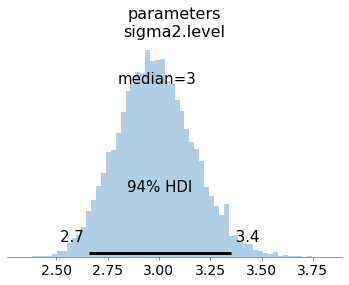

In [7]:
nburn = 10000
nthin = 10

# Convert for use with ArviZ and plot posterior
samples_rw = az.convert_to_inference_data(
    {'parameters': samples_rw[None, ..., None]},
    coords={'parameter': model_rw.param_names},
    dims={'parameters': ['parameter']})
ax = az.plot_posterior(samples_rw.posterior.sel(
    {'draw': np.s_[nburn::nthin]}), kind='bin', point_estimate='median');

With that, we have completed the most basic illustration of Bayesian estimation via Random walk Metropolis-Hastings, using Statsmodels.

However, there are many extensions we could incorporate, and diagnostic tests that we could run (for example, to check whether we have run our Markov chain long-enough to be confident that we are drawing from the approximate posterior).

## Application 2: Gibbs sampling with a local level model

In our second application, we consider applying a slightly more general model to U.S. Industrial Production. The "local level" model generalizes the random walk model by assuming that the observed data is the sum of a random walk component and an error term. In this way, not all of the movements in the series are passed into the estimates of the trend. To be specific, the model is:

$$
\begin{aligned}
y_t & = \mu_t + \varepsilon_t, ~~~\qquad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
\mu_t & = \mu_{t-1} + \zeta_t, \qquad \zeta_t \sim N(0, \sigma_\zeta^2)
\end{aligned}
$$

This model now has two parameters that we will estimate: $\sigma_\varepsilon^2$ and $\sigma_\zeta^2$.

**Constructing the model in Statsmodels**

The local level model can also be constructed using the `UnobservedComponents` class in Statsmodels. Here, we apply the model to U.S. Consumer Price Index inflation.

In [8]:
# Load data
mdata = sm.datasets.macrodata.load().data
mdata.index = pd.date_range('1959Q1', '2009Q3', freq='QS')

cpi = np.log(mdata['cpi']).diff().iloc[1:] * 400

In [9]:
# Construct an object that contains our dataset, `cpi`,
# and specifies the model, here local level
model_ll = sm.tsa.UnobservedComponents(cpi, 'local level')

# Check the parameters that the model depends on
# two variance terms:
print(model_ll.param_names)

['sigma2.irregular', 'sigma2.level']


Here `sigma2.irregular` corresponds to $\sigma_\varepsilon^2$, while `sigma2.level` corresponds to $\sigma_\zeta^2$.

### Estimating $\sigma_\varepsilon^2, \sigma_\zeta^2$ using Gibbs Sampling

As before, we will need to specify priors for the parameters. However, Gibbs Sampling is only valid when we can construct conditional posterior distributions analytically. In practice, this means that we are limited in the family of priors that we can choose. In this case, we will use [inverse-Gamma priors](https://en.wikipedia.org/wiki/Inverse-gamma_distribution) for each of the variance terms. The inverse-Gamme distribution only has support over strictly positive real numbers, and is often a useful prior for variance parameters. We are still free to choose the hyperparameters of the distribution; here we select values that imply an uninformative, or weak, prior.

In [10]:
# Specify the prior distributions. With GS, we
# must choose an inverse Gamma prior for each
# variance
priors = [stats.invgamma(0.001, scale=0.001)] * 2

**Simulation smoother**

When using Gibbs sampling, we do not need to use the accept-reject scheme shown above for sampling parameters. Instead, our choice of prior can be combined with the model likelihood to draw directly from conditional posterior distributions.

In the case of models with unobserved latent states (in the local level model, $\mu_t$ is such a latent state), we need to be able to draw from the conditional posterior of the latent states (conditional on the data and the variance parameter values). For linear Gaussian state space models (of which the local level model is a special case), such a draw can be constructed with the use of a "simulation smoother".

In `Statsmodels`, a simulation smoother object can be constructed using the `simulation_smoother` method.

**Performance note** the simulation smoother will by default draw more values than we need for Gibbs sampling. To improve performance, we specify the arugment `simulate_state=True`, which instructs the simulation smoother to only draw the state vector.

In [11]:
# Construct the simulation smoother
sim_ll = model_ll.simulation_smoother(simulate_state=True)

**Gibbs sampling iterations**

Below we perform the Gibbs sampling iterations. Notice that instead of the accept-reject scheme used with random walk Metropolis-Hastings, we (1) sample from the conditional posterior of the latent states, and then (2) sample from the conditional posteriors of the two variance parameters.

In [12]:
# Storage
niter = 100000
samples_ll = np.zeros((niter + 1, 2))

# Initialization
samples_ll[0] = [cpi.diff().var(), 1e-5]

# Iterations
for i in range(1, niter + 1):
    # Update the model parameters
    model_ll.update(samples_ll[i - 1])
    # Draw from the conditional posterior of
    # the state vector
    sim_ll.simulate()
    sample_state = sim_ll.simulated_state.T

    # Compute / draw from conditional posterior of
    # ...observation error variance
    resid = cpi - sample_state[:, 0]
    post_shape = len(resid) / 2 + 0.01
    post_scale = np.sum(resid**2) / 2 + 0.01
    samples_ll[i, 0] = stats.invgamma(
        post_shape, scale=post_scale).rvs()

    # ...level error variance
    resid = sample_state[1:] - sample_state[:-1]
    post_shape = len(resid) / 2 + 0.01
    post_scale = np.sum(resid**2) / 2 + 0.01
    samples_ll[i, 1] = stats.invgamma(
        post_shape, scale=post_scale).rvs()

As before, we will use ArviZ to visualize the results. Now, since we have two parameters instead of one, we visualize the approximate joint posterior using a hexbin plot.

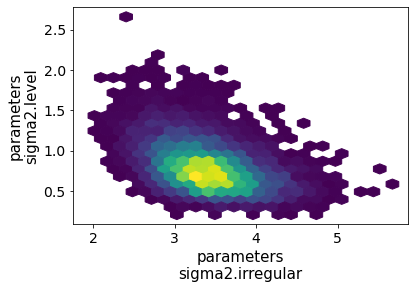

In [13]:
nburn = 10000
nthin = 10

# Convert for use with ArviZ and plot posterior
samples_ll = az.convert_to_inference_data(
    {'parameters': samples_ll[None, ...]},
    coords={'parameter': model_ll.param_names},
    dims={'parameters': ['parameter']})
ax = az.plot_pair(samples_ll.posterior.sel(
    {'draw': np.s_[nburn::nthin]}), kind='hexbin');

## Extra: Abstracting out the MCMC logic

Although the examples above were very simple, they illustrate the basic principles of random walk Metropolis-Hastings and Gibbs sampling. We can abstract those operations out into two simple functions that we will use later, to avoid repeating ourselves in each application.

In [14]:
def draw_mh_step(mod, ix, params, llf, prior_llf, prior, rw, uniform):
    """
    Sample a parameter in RWMH iteration
    
    Parameters
    ----------
    mod : sm.tsa.statespace.mlemodel.MLEModel
        State space model object (for example, in the two
        applications above this would have been an instance
        of sm.tsa.UnobservedComponents)
    ix : int
        Index of the parameter to be sampled within
        the `params` array.
    params : array_like
        Current values of the parameters in the Markov
        chain.
    llf : float
        Log-likelihood of the data at the given `params`
        array.
    prior_llf : float
        Prior log-likelihood of `params[ix]`
    prior : scipy random variable object
        Prior distribution (e.g. the example of this from
        above was `stats.uniform(0.001, 100)`).
    rw : stats.norm object
        Perturbation distribution. Should be Normal with
        mean zero.
    uniform : stats.uniform object
        Standard uniform distribution object (used for
        choosing whether to accept the proposal)
        
    Returns
    -------
    draw : float
        Sampled parameter at index `ix`.
    accept : bool
        Whether or not the proposal was accepted.
    llf : float
        Log-likelihood of the data after accepting or
        rejecting the proposal.
    prior_llf : float
        Prior log-likelihood of sampled `draw`.
    """
    accept = 0

    # Draw the proposal value from the random walk
    # proposal distribution
    proposal = params.copy()
    proposal[ix] += rw.rvs()
    proposal_prior_llf = prior.logpdf(proposal[ix])

    # (if the proposal is not in the support of the
    # prior, then we definitely won't accept it)
    if proposal_prior_llf > -np.inf:

        # Construct the acceptance probability
        proposal_llf = mod.loglike(proposal)
        inner = (proposal_llf - llf +
                 proposal_prior_llf - prior_llf)

        if inner > 0:
            acceptance_probability = 1
        else:
            acceptance_probability = np.exp(inner)

        # If we accept the proposal, save the parameter
        # and likelihood values
        if (acceptance_probability == 1
                or acceptance_probability > uniform.rvs()):
            params[ix] = proposal[ix]
            llf = proposal_llf
            prior_llf = proposal_prior_llf
            accept = 1

        # Note: if we didn't accept, then `params[ix]`
        # is unmodified from what was originally passed
        # in to the function

    return params[ix], accept, llf, prior_llf

In [15]:
def draw_ig_gs_step(equation, ix, mod, states, prior):
    """
    Sample a variance parameter in Gibbs sampling iteration
    
    Assumes a state space model and an inverse-Gamma prior.
    
    Parameters
    ----------
    equation : {'observation', 'state'}
        State space system equation in which the variance
        parameter occurs.
    ix : int or iterable of int
        Index of the variance parameter or parameters to be
        sampled within the given equation. For example, if
        `equation="observation"` and `ix=[0, 1]`, then this
        function samples the variance associated with the
        first column of the data.
    mod : sm.tsa.statespace.mlemodel.MLEModel
        State space model object (for example, in the two
        applications above this would have been an instance
        of sm.tsa.UnobservedComponents)
    states : array_like
        Current values of the latent state vector in the
        Markov chain.
    prior : stats.invgamma object or list of stats.invgamma
        Prior distribution(s) for the variance parameter(s).
        
    Returns
    -------
    draw : float or array_like
        Sampled parameter(s) at index `ix` in equation
        `equation`.
    """
    # Retrieve the prior hyperparameters
    if isinstance(prior, (list, tuple)):
        prior_shape = np.array([p.args[0] for p in prior])
        prior_scale = np.array([p.kwds['scale'] for p in prior])
    else:
        prior_shape = prior.args[0]
        prior_scale = prior.kwds['scale']

    # Compute the appropriate residual
    if equation == 'observation':
        d = mod['obs_intercept', ix]
        Z = mod['design', ix, :]
        resid = mod.endog[:, ix] - d - states @ Z.T
    elif equation == 'state':
        c = mod['state_intercept', ix]
        T = mod['transition', ix, :]
        resid = states[1:, ix] - c - states[:-1] @ T.T

    squeeze = False
    if resid.ndim == 1:
        squeeze = True
        resid = resid[:, np.newaxis]

    # Draw from the conditional posterior
    post_shape = np.sum(~np.isnan(resid), axis=0) / 2 + prior_shape
    post_scale = np.nansum(resid**2, axis=0) / 2 + prior_scale
    draw = np.array([stats.invgamma(post_shape[i], scale=post_scale[i]).rvs()
                     for i in range(resid.shape[1])])

    if squeeze:
        draw = draw[0]

    return draw

## Application 3: forecasting and seasonal adjustment, with Gibbs Sampling

In our third application, we will show how to augment our Gibbs sampling iterations to forecast U.S. Industrial Production. To make the model more realistic, we will also generalize the model still further to allow for trending behavior and to incorporate a seasonal component.

The model is:

$$
\begin{aligned}
   \hspace{7.5em} y_t & = \mu_t + \gamma_t + \varepsilon_t & \hspace{2em} \text{observation equation} \\
   \mu_t & = \beta_t + \mu_{t-1} + \zeta_t & \text{level} \\
   \beta_t & = \beta_{t-1} + \xi_t & \text{trend} \\
   \gamma_t & = \gamma_{t-s} + \eta_t & \text{seasonal} 
   \end{aligned}
   $$
   
The Markov chain Monte Carlo sampling iterations not only produce draws of the model parameters from the approximate posterior distribution, but can also produce draws of (a) the latent states, and (b) forecasts of the observed variable from their respective approximate posterior distributions.

In addition to producing forecasts, these draws allow us to estiamte the latent states, including the level, trend and seasonal components. In addition to being interesting in and of themselves, we can use the samples of the seasonal factors to construct a seasonally adjusted version of industrial production.


**Constructing the model in Statsmodels**

This model can also be constructed using the `UnobservedComponents` class in Statsmodels, as before. Since we will be using Gibbs sampling, we will also construct the required simulation smother object (and as described above, we specify `simulate_state=True` to improve performance).

In [16]:
# Construct the model object...
mod = sm.tsa.UnobservedComponents(y, 'lltrend', seasonal=12, use_exact_diffuse=True)

# ... and simulation smoother object
sim = mod.simulation_smoother(simulate_state=True)

# Print the parameters
print(mod.param_names)

['sigma2.irregular', 'sigma2.level', 'sigma2.trend', 'sigma2.seasonal']


**Priors**

As shown above, the model now depends on four parameters, each of which are variances. Since we wish to apply Gibbs sampling, we specify inverse Gamma distributions for each, and choose the hyperparameters to imply uninformative priors.

In [17]:
# Priors
priors = [stats.invgamma(0.001, scale=0.001)] * 4

**Forecasting**

We now need to set up the details of the forecasting exercise. Here, we choose to forecast for 100 periods, and construct a `DatetimeIndex` that will be associated with those periods.

In [18]:
# Forecast
n_fcast = 100
ix = pd.date_range(y.index[0], periods=len(y) + n_fcast, freq='MS')
fcast_ix = ix[-n_fcast:]

**Storage**

In the previous applications, we placed the draws from each iteration into numpy arrays, and then later constructed ArviZ objects from those arrays.

Here we'll show a different approach and place the draws from each iteration into xarray objects. These can also be used with ArviZ, as we illustrate afterwards.

In [19]:
# Storage
niter = 100000
params = xr.DataArray(np.zeros((niter + 1, mod.k_params)),
                      dims=['draw', 'param'],
                      coords={'param': mod.param_names},
                      name='params')
states = xr.DataArray(np.zeros((niter + 1, mod.nobs, mod.k_states)),
                      dims=['draw', 'date', 'state'],
                      coords={'date': mod._index.rename('date'),
                              'state': mod.state_names},
                      name='states')
fcast = xr.DataArray(np.zeros((niter + 1, n_fcast, mod.k_endog)),
                     dims=['draw', 'date', 'variable'],
                     coords={'date': fcast_ix,
                             'variable': [mod.endog_names]},
                     name='forecast')

**Gibbs sampling iterations**

The iterations here are similar to those from the previous example, except that now we use the function `draw_ig_gs_step` that we defined earlier, to keep the code concise.

In [20]:
# Initial values
params[0] = mod.fit(disp=False).params

# Iterations
for i in range(1, niter + 1):
    if (i % max(200, niter // 20)) == 0:
        print(i)
        
    # Sample from state posterior
    mod.update(params[i - 1])
    sim.simulate()
    states[i] = sim.simulated_state.T

    # Predictive simulation from sample end
    fcast[i] = mod.simulate(params[i - 1], n_fcast,
                            initial_state=states[i, -1]).to_frame()

    # Gibbs sampling
    params[i, 0] = draw_ig_gs_step(
        'observation', 0, mod, sim.simulated_state.T, priors[0])
    params[i, 1:4] = draw_ig_gs_step(
        'state', [0, 1, 2], mod, sim.simulated_state.T, priors[1:4])


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


**Visualizing the approximate posteriors with ArviZ**

Because ArviZ accepts xarray objects, we can directly pass our `params` vector to the `plot_posterior` function.

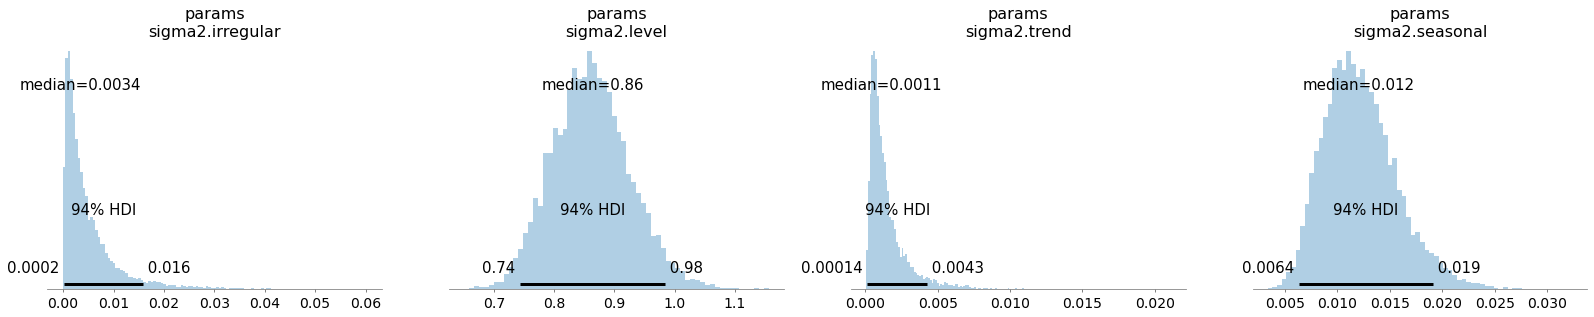

In [21]:
nburn = 10000
nthin = 10
az.plot_posterior(params.sel(draw=np.s_[nburn + 1::nthin]),
                  point_estimate='median', kind='hexbin');

**Visualizing the forecasts**

The forecasts are also stored in an xarray object. Below we will plot the median forecast along with the 90/10 credible interval.

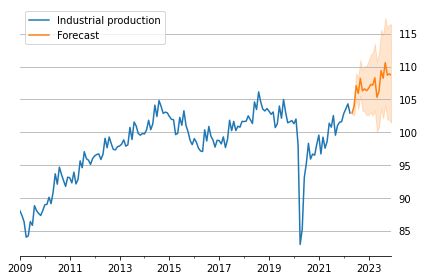

In [22]:
fig, ax = plt.subplots()

# Plot the observed data
ax = y.loc['2009':].rename('Industrial production').plot(ax=ax)

# Plot the median forecast, through December 2023
fcast_plot = fcast.sel(draw=np.s_[nburn + 1::nthin], date=np.s_[:'2023-12':])
fcast_plot.median(axis=0).to_pandas()['IPB50001N'].rename('Forecast').plot(ax=ax)

# Plot the 90/10 credible interval
ax.fill_between(fcast_plot.coords['date'].to_index(),
                fcast_plot.quantile(0.1, dim='draw')[:, 0],
                fcast_plot.quantile(0.9, dim='draw')[:, 0],
                color='C1', alpha=0.2)

# Finalize the plot
ax.legend(loc='upper left')
ax.set_xlabel(None)
ax.yaxis.set_label_coords(1, 1)
ax.yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
ax.yaxis.grid()
[ax.spines[s].set_visible(False) for s in ['left', 'top', 'right']]
fig.tight_layout()

**Visualizing the estimated latent states**

As noted above, the `states` xarray object contains draws from the approximate posterior of the latent states. Below, we plot the medians and 90/10 credible intervals for the level, trend, and seasonal components.

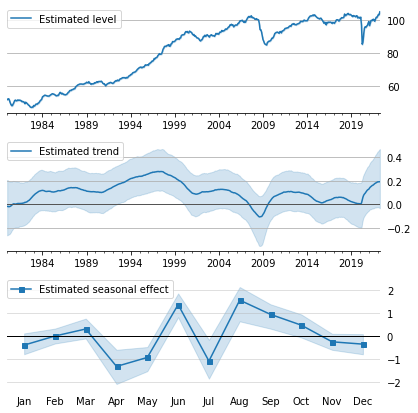

In [23]:
fig, axes = plt.subplots(3, figsize=(6, 6));

states_plot = states.sel(draw=np.s_[nburn + 1::nthin])
level = states_plot.sel(state='level')
trend = states_plot.sel(state='trend')
seasonal = states_plot.sel(state='seasonal')

# Plot the estimated level, over time
level.median(axis=0).to_pandas().rename('Estimated level').plot(ax=axes[0])
axes[0].fill_between(level.coords['date'].to_index(),
                     level.quantile(0.1, dim='draw'),
                     level.quantile(0.9, dim='draw'),
                     color='C0', alpha=0.2)
axes[0].legend(loc=(0, 0.80))
axes[0].set_xlabel(None)
axes[0].yaxis.set_label_coords(1, 1)
axes[0].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[0].yaxis.grid()
[axes[0].spines[s].set_visible(False) for s in ['left', 'top', 'right']]

# Plot the estimated trend, over time
trend.median(axis=0).to_pandas().rename('Estimated trend').plot(ax=axes[1])
axes[1].fill_between(trend.coords['date'].to_index(),
                     trend.quantile(0.1, dim='draw'),
                     trend.quantile(0.9, dim='draw'),
                     color='C0', alpha=0.2)
axes[1].axhline(0, color='k', linestyle='--', linewidth=1, zorder=0)
axes[1].legend(loc=(0, 0.85))
axes[1].set_xlabel(None)
axes[1].yaxis.set_label_coords(1, 1)
axes[1].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[1].yaxis.grid()
axes[1].axhline(0, color='#555', linewidth=1)
[axes[1].spines[s].set_visible(False) for s in ['left', 'top', 'right']]

# Plot the estimated seasonal components, aggregated over time
x = seasonal.T.to_pandas()
x.index = x.index.month.rename('month')
x = x.T.melt()
g = x.groupby('month')
gm = g.median()['value']
gm.index = np.arange(12)
gm.rename('Estimated seasonal effect').plot(ax=axes[2], marker='s', markersize=5)
axes[2].legend(loc=(0, 0.85))
axes[2].fill_between(np.arange(12),
                     g.quantile(0.1)['value'],
                     g.quantile(0.9)['value'],
                     color='C0', alpha=0.2)
axes[2].xaxis.set_ticks(np.arange(0, 12))
axes[2].xaxis.set_ticklabels(pd.period_range('2020', periods=12, freq='M').strftime('%b'))
axes[2].set_xlabel('')
axes[2].axhline(0, color='k', linewidth=1)
axes[2].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[2].yaxis.grid(alpha=0.5)
axes[2].xaxis.set_tick_params(bottom=False)
[axes[2].spines[s].set_visible(False) for s in ['left', 'top', 'right', 'bottom']]

fig.suptitle('')
fig.tight_layout()

**Constructing a seasonally adjusted index**

A seasonally adjusted index $z_t$ can be constructed by subtracting the estimated seasonal factor from the observed variable:

$$
z_t = (y_t - \hat \gamma_t) \approx \mu_t + \varepsilon_t
$$

In [24]:
# Construct the seasonally adjusted index
z = (-seasonal.to_pandas().T).add(y, axis=0)

To better illustrate how the seasonally adjusted series eliminates the seasonal patterns, we focus on the the five year period from 2014 - 2019:

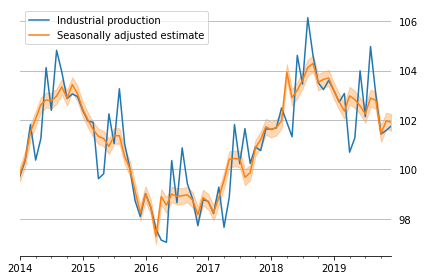

In [25]:
fig, ax = plt.subplots()

# Plot the observed data
ax = y.loc['2014':'2019'].rename('Industrial production').plot(ax=ax)

# Plot the median and 90/10 credible interval, along with the
q = z.loc['2014':'2019'].quantile([0.1, 0.5, 0.9], axis=1).T
q[0.5].rename('Seasonally adjusted estimate').plot(ax=ax)
ax.fill_between(q.index, q[0.1], q[0.9], color='C1', alpha=0.3)

# Finalize the plot
ax.legend(loc='upper left')
ax.set_xlabel(None)
ax.yaxis.set_label_coords(1, 1)
ax.yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
ax.yaxis.grid()
[ax.spines[s].set_visible(False) for s in ['left', 'top', 'right']]
fig.tight_layout()

## Application 3: computing the "causal impact" of an intervention

One use of Bayesian structural time series (BSTS) models that has grown in popularity is in constructing counterfactual predictions from which to assess the impact of some intervention. 

The use of this type of approach in assessing a "causal impact" was described in the Annals of Statistics paper ["Inferring causal impact using Bayesian structural time-series models"](https://research.google/pubs/pub41854/) (Brodersen et al., 2015), and was popularized via the accompanying [CausalImpact](https://google.github.io/CausalImpact/CausalImpact.html) library in R.

The basic approach to estimating this type of model is the same as above, except that we will only estimate our model over a dataset that ends just prior to the intervention. The forecasts produced by the model can then be compared to the actual data over the subsequent period.

To illustrate this type of analysis, we consider the effect of the COVID-19 pandemic on [Real Manufacturing and Trade Industries Sales](https://fred.stlouisfed.org/series/CMRMTSPL).

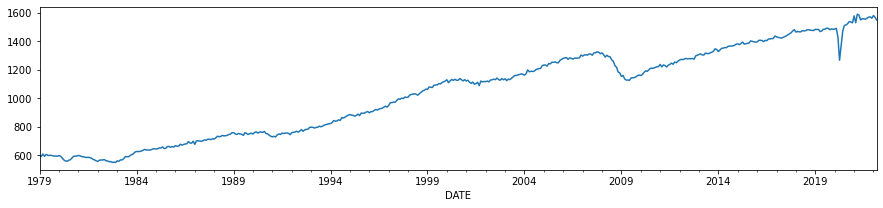

In [26]:
# Retrieive Real Manufacturing and Trade Industries Sales
# and rescale
CMRMTSPL = DataReader('CMRMTSPL', 'fred',
                      start='1979', end='2022-03')['CMRMTSPL'].asfreq('MS') / 1000

# Plot the dataset
CMRMTSPL.plot(figsize=(15, 3));

The data shows a clear trend, but it has no obvious seasonal pattern (since it has already been seasonally adjusted). Therefore, we select a local linear trend model.

Since the steps are the same as above, we present them all at once below:

In [27]:
# Subset the data to just before the COVID-19 pandemic
y = CMRMTSPL.loc[:'2020-02']

# Create the model and state simulation smoother
mod = sm.tsa.UnobservedComponents(y, 'lltrend', use_exact_diffuse=True)
sim = mod.simulation_smoother(simulate_state=True)

# Forecast details
n_fcast = len(CMRMTSPL) - len(y)
ix = CMRMTSPL.index.rename('date')
fcast_ix = ix[-n_fcast:]

# Priors
priors = [stats.invgamma(0.001, scale=0.001)] * 3

# Storage
niter = 100000
params = xr.DataArray(np.zeros((niter + 1, mod.k_params)),
                      dims=['draw', 'param'],
                      coords={'param': mod.param_names},
                      name='params')
states = xr.DataArray(np.zeros((niter + 1, mod.nobs, mod.k_states)),
                      dims=['draw', 'date', 'state'],
                      coords={'date': mod._index.rename('date'),
                              'state': mod.state_names},
                      name='states')
predict = xr.DataArray(np.zeros((niter + 1, mod.nobs + n_fcast, mod.k_endog)),
                       dims=['draw', 'date', 'variable'],
                       coords={'date': ix,
                               'variable': [mod.endog_names]},
                       name='forecast')

# Initial values
params[0] = mod.fit(disp=False).params

# Iterations
for i in range(1, niter + 1):
    if (i % max(200, niter // 20)) == 0:
        print(i)
        
    # Sample from state posterior
    mod.update(params[i - 1])
    sim.simulate()
    states[i] = sim.simulated_state.T

    # Predictive simulation
    in_sample = pd.Series(
        (mod['design'] @ sim.simulated_state)[0].T,
        index=y.index)
    out_of_sample = mod.simulate(params[i - 1], n_fcast,
                                 initial_state=states[i, -1])
    predict[i] = pd.concat([in_sample, out_of_sample]).to_frame()

    # Gibbs sampling
    params[i, 0] = draw_ig_gs_step('observation', 0, mod, sim.simulated_state.T, priors[0])
    params[i, 1:] = draw_ig_gs_step('state', [0], mod, sim.simulated_state.T, priors[1:])


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


**Constructing the impacts**

To construct the impacts, we need to first construct the model predictions. Then the point-wise impacts are equal to the observed data minus the model predictions, and the cumulative impacts are just the cumulative sum of the pointwise impacts.

In [28]:
start = '2019'
nburn = 10000
nthin = 10

# Compute the median and 70/30 credible interval for
# the model prediction
predict_plot = predict.sel(draw=np.s_[nburn + 1::nthin])
predict_median = predict_plot.median(dim='draw').to_pandas().iloc[:, 0]
predict_lower = predict_plot.quantile(0.3, dim='draw').sel(date=np.s_['2020-02':])[:, 0]
predict_upper = predict_plot.quantile(0.7, dim='draw').sel(date=np.s_['2020-02':])[:, 0]

# Compute the median and 70/30 credible interval for
# the point-wise impact of the intervention (which is
# equal to "actual data - model prediction")
predict_diff = (xr.DataArray(CMRMTSPL.to_frame(), dims=['date', 'variable']) - predict_plot)
predict_diff_median = predict_diff.median(dim='draw').to_pandas().iloc[:, 0]
predict_diff_lower = predict_diff.quantile(0.3, dim='draw').sel(date=np.s_['2020-02':])[:, 0]
predict_diff_upper = predict_diff.quantile(0.7, dim='draw').sel(date=np.s_['2020-02':])[:, 0]

# Compute the median and 70/30 credible interval for
# the cumulative-wise impact of the intervention (which is
# equal to the cumulative sum of the pointwise impact)
predict_diff_cumul = predict_diff.loc[start:].cumsum(dim='date')
predict_diff_cumul_median = predict_diff_cumul.median(dim='draw').to_pandas().iloc[:, 0]
predict_diff_cumul_lower = (
    predict_diff_cumul.quantile(0.3, dim='draw').sel(date=np.s_['2020-02':])[:, 0])
predict_diff_cumul_upper = (
    predict_diff_cumul.quantile(0.7, dim='draw').sel(date=np.s_['2020-02':])[:, 0])

Finally, we plot the predictions, point-wise impacts, and cumulative impacts, along with 70/30 credible intervals.

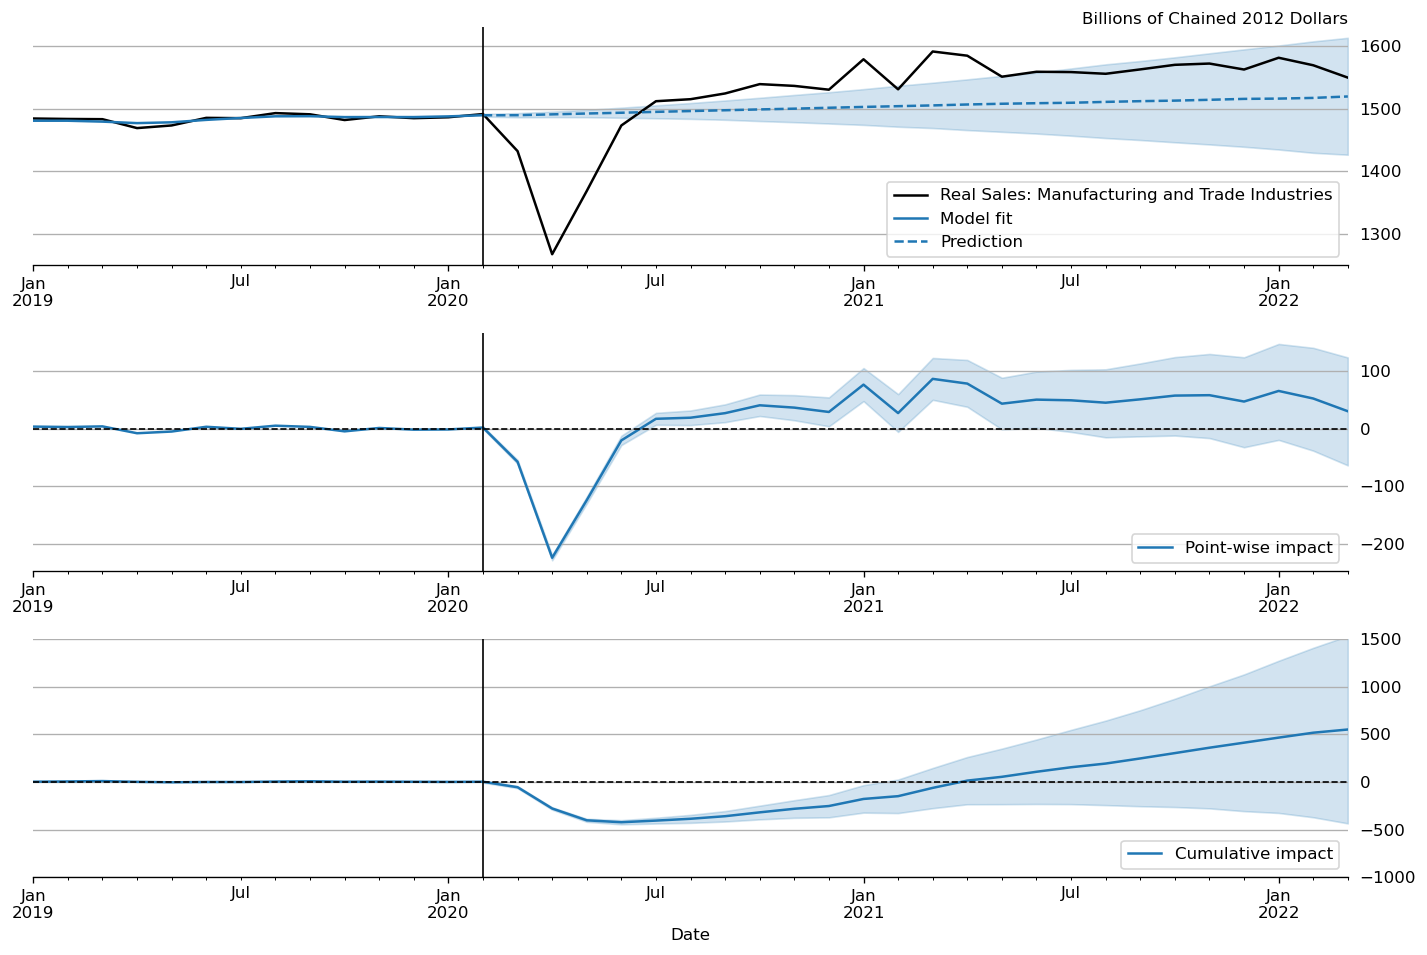

In [29]:
fig, axes = plt.subplots(3, figsize=(12, 8), dpi=120)

# Plot observed data against the model predictions
(CMRMTSPL.loc[start:].rename('Real Sales: Manufacturing and Trade Industries')
         .plot(color='k', ax=axes[0]))
predict_median.loc[start:'2020-02'].rename('Model fit').plot(ax=axes[0])
predict_median.loc['2020-02':].rename('Prediction').plot(
    ax=axes[0], color='C0', linestyle='--')
axes[0].fill_between(predict_lower.coords['date'].to_index(),
                     predict_lower,
                     predict_upper,
                     color='C0', alpha=0.2)
axes[0].legend(loc='lower right')
axes[0].axvline('2020-02', color='k', linewidth=1)
axes[0].set_ylabel('Billions of Chained 2012 Dollars', loc='top', rotation="horizontal")
axes[0].set_xlabel(None)
axes[0].yaxis.set_label_coords(1, 1)
axes[0].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[0].yaxis.grid()
[axes[0].spines[s].set_visible(False) for s in ['left', 'top', 'right']]

# Plot the point-wise impacts
predict_diff_median.loc[start:].rename('Point-wise impact').plot(ax=axes[1])
axes[1].fill_between(predict_diff_lower.coords['date'].to_index(),
                     predict_diff_lower,
                     predict_diff_upper,
                     color='C0', alpha=0.2)
axes[1].axvline('2020-02', color='k', linewidth=1)
axes[1].axhline(0, color='k', linewidth=1, linestyle='--')
axes[1].legend(loc='lower right')
axes[1].set_xlabel(None)
axes[1].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[1].yaxis.grid()
[axes[1].spines[s].set_visible(False) for s in ['left', 'top', 'right']]

# Plot the cumulative impacts
predict_diff_cumul_median.loc[start:].rename('Cumulative impact').plot(ax=axes[2])
axes[2].fill_between(predict_diff_cumul_lower.coords['date'].to_index(),
                     predict_diff_cumul_lower,
                     predict_diff_cumul_upper,
                     color='C0', alpha=0.2)
axes[2].axvline('2020-02', color='k', linewidth=1)
axes[2].axhline(0, color='k', linewidth=1, linestyle='--')
axes[2].legend(loc='lower right')
axes[2].set_ylim(-1000, 1500)
axes[2].set_xlabel('Date')
axes[2].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[2].yaxis.grid()
[axes[2].spines[s].set_visible(False) for s in ['left', 'top', 'right']]

fig.tight_layout()